In [ ]:
pip install pandas-profiling[notebook]

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import pandas_profiling as pp
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

In [3]:
df = pd.read_csv(r'C:\Users\Vamshikrishna\Desktop\Heart attack Analysis and prediction\heart.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trtbps    303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalachh  303 non-null    int64  
 8   exng      303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slp       303 non-null    int64  
 11  caa       303 non-null    int64  
 12  thall     303 non-null    int64  
 13  output    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


In [4]:
pp.ProfileReport(df)

Summarize dataset:   0%|          | 0/27 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [5]:
df.columns

Index(['age', 'sex', 'cp', 'trtbps', 'chol', 'fbs', 'restecg', 'thalachh',
       'exng', 'oldpeak', 'slp', 'caa', 'thall', 'output'],
      dtype='object')

In [6]:
df = df[df.chol<380]
df = df[df.trtbps<190]
df = df[df.thalachh>75]


In [7]:
df.shape

(295, 14)

In [9]:
X = df.drop('output', axis=1)
y = df.output
X = StandardScaler().fit(X).transform(X)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25, random_state=0)

In [12]:
ks = 30
mean_acc = np.zeros((ks-1))
std_acc = np.zeros((ks-1))
ConfusionMX = [];
for n in range(1,ks):
    #Train model and Predict
    neigh = KNeighborsClassifier(n_neighbors=n).fit(X_train, y_train)
    yhat = neigh.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)
    std_acc[n-1] = np.std(yhat==y_test)/np.sqrt(yhat.shape[0])
mean_acc

array([0.77027027, 0.83783784, 0.86486486, 0.87837838, 0.83783784,
       0.87837838, 0.83783784, 0.83783784, 0.81081081, 0.86486486,
       0.81081081, 0.83783784, 0.83783784, 0.86486486, 0.85135135,
       0.86486486, 0.83783784, 0.85135135, 0.83783784, 0.86486486,
       0.85135135, 0.86486486, 0.83783784, 0.83783784, 0.82432432,
       0.83783784, 0.85135135, 0.83783784, 0.83783784])

Model Selection and Hyperparameter Tunning

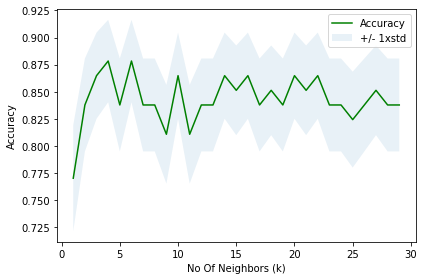

In [15]:
#Plot model accuracy for Different number of neighbord

plt.plot(range(1,ks),mean_acc,'g')
plt.fill_between(range(1,ks), mean_acc-1 * std_acc, mean_acc+1 * std_acc, alpha=0.10)
#showing 68% data

plt.legend(('Accuracy','+/- 1xstd'))
plt.xlabel('No Of Neighbors (k)')
plt.ylabel('Accuracy')
plt.tight_layout()
plt.show()

In [16]:
scores=[]
best_estimators = {}


model_params = {  
    
    
    'KNeighborsClassifier': {
        'model': KNeighborsClassifier(),
        'params': {
            'n_neighbors': [2,3,4,5,6,7,18,19,20],
            'algorithm' : ['auto','ball_tree'],
            'weights' : ['uniform','distance'],
            'leaf_size' : [27,28,29,30,31]
        }
    },
    
    'DecisionTreeClassifier': {
        'model': DecisionTreeClassifier(),
        'params': {
            'criterion': ['gini','entropy'],
            'max_depth' : [None,1,2,6,5]
        }
    },
    
    
    'AdaBoostClassifier': {
        'model': AdaBoostClassifier(),
        'params': {
            'n_estimators': [30,35,40,45,50,55],
            'learning_rate' : [1,1.1,1.2,1.3,1.4,1.5],
            'algorithm' : ['SAMME', 'SAMME.R']
        }
    },
    
    'GaussianNB': {
        'model': GaussianNB(),
        'params': {
            
        }
    },
    
     'LOGISTIC_REGRESSION': {
        'model': LogisticRegression(),
        'params': {
            'C': [1,2,3,4,5,6,7],
            'solver' : [ 'liblinear', 'lbfgs'],
            'multi_class' : ['auto', 'ovr' ]
        }
    },
    
        
    'SVM': {
        'model': SVC(),
        'params': {
             'C': [1,2,3,5,6,7],
             'kernel': ['rbf','linear'],
             'gamma': ['auto', 'scale']
        }
    },
       
    'RANDOM_FOREST':{
        'model' : RandomForestClassifier(),
        'params': {
            'n_estimators':[1,2,3,4,5,10,15],
            'criterion': ['entropy'],
            'random_state' : [12,13],
            'max_depth' : [5,6]

        }
    }
}

In [17]:
import time


for model_name, mp in model_params.items():
    clf = GridSearchCV(mp['model'], mp['params'], cv=5, return_train_score=False)
    print(mp['model'], mp['params'])
    start_time = time.time()
    
    clf.fit(X_train, y_train)    
    

    scores.append({
        'model': model_name,
        'best_score': clf.best_score_,
        'best_params': str(clf.best_params_)
    })
    best_estimators[model_name] = clf.best_estimator_
    print('{} minutes'.format((time.time() - start_time)/60))


KNeighborsClassifier() {'n_neighbors': [2, 3, 4, 5, 6, 7, 18, 19, 20], 'algorithm': ['auto', 'ball_tree'], 'weights': ['uniform', 'distance'], 'leaf_size': [27, 28, 29, 30, 31]}
0.06766084432601929 minutes
DecisionTreeClassifier() {'criterion': ['gini', 'entropy'], 'max_depth': [None, 1, 2, 6, 5]}
0.0019155581792195638 minutes
AdaBoostClassifier() {'n_estimators': [30, 35, 40, 45, 50, 55], 'learning_rate': [1, 1.1, 1.2, 1.3, 1.4, 1.5], 'algorithm': ['SAMME', 'SAMME.R']}
0.5422003030776977 minutes
GaussianNB() {}
0.0002331852912902832 minutes
LogisticRegression() {'C': [1, 2, 3, 4, 5, 6, 7], 'solver': ['liblinear', 'lbfgs'], 'multi_class': ['auto', 'ovr']}
0.015826125939687092 minutes
SVC() {'C': [1, 2, 3, 5, 6, 7], 'kernel': ['rbf', 'linear'], 'gamma': ['auto', 'scale']}
0.014400017261505128 minutes
RandomForestClassifier() {'n_estimators': [1, 2, 3, 4, 5, 10, 15], 'criterion': ['entropy'], 'random_state': [12, 13], 'max_depth': [5, 6]}
0.033364264170328777 minutes


In [18]:
import pandas as pd    
df2 = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df2 = df2.sort_values(by='best_score',ascending=False)
df2

,model,best_score,best_params
5,SVM,0.828283,"{'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}"
6,RANDOM_FOREST,0.828283,"{'criterion': 'entropy', 'max_depth': 5, 'n_es..."
0,KNeighborsClassifier,0.823636,"{'algorithm': 'auto', 'leaf_size': 27, 'n_neig..."
3,GaussianNB,0.823535,{}
2,AdaBoostClassifier,0.819293,"{'algorithm': 'SAMME', 'learning_rate': 1.3, '..."
4,LOGISTIC_REGRESSION,0.814545,"{'C': 2, 'multi_class': 'auto', 'solver': 'lib..."
1,DecisionTreeClassifier,0.800808,"{'criterion': 'entropy', 'max_depth': 6}"


In [19]:
df2.best_params[0]

"{'algorithm': 'auto', 'leaf_size': 27, 'n_neighbors': 7, 'weights': 'uniform'}"

In [20]:
cross_val_score(best_estimators['RANDOM_FOREST'],X_test,y_test,cv=5).mean()


0.7838095238095237

In [21]:
cross_val_score(best_estimators['KNeighborsClassifier'],X_test,y_test,cv=5).mean()


0.7838095238095237

In [22]:
cross_val_score(best_estimators['GaussianNB'],X_test,y_test,cv=5).mean()


0.8104761904761905

In [23]:
cross_val_score(best_estimators['DecisionTreeClassifier'],X_test,y_test,cv=5).mean()


0.8114285714285714

In [24]:
cross_val_score(best_estimators['SVM'],X_test,y_test,cv=5).mean()


0.7838095238095237

In [25]:
cross_val_score(best_estimators['AdaBoostClassifier'],X_test,y_test,cv=5).mean()

0.7961904761904762

Best model Evaluation

In [26]:
best_clf = best_estimators['RANDOM_FOREST']
best_clf

RandomForestClassifier(criterion='entropy', max_depth=5, n_estimators=10,
                       random_state=13)

In [27]:
from sklearn.metrics import classification_report
print(classification_report(y_test,best_clf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.90      0.74      0.81        38
           1       0.77      0.92      0.84        36

    accuracy                           0.82        74
   macro avg       0.84      0.83      0.82        74
weighted avg       0.84      0.82      0.82        74



In [28]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, best_clf.predict(X_test))
cm

array([[28, 10],
       [ 3, 33]], dtype=int64)

In [29]:
class_dict = {'Normal':0, 'Prone to heart attack':1}

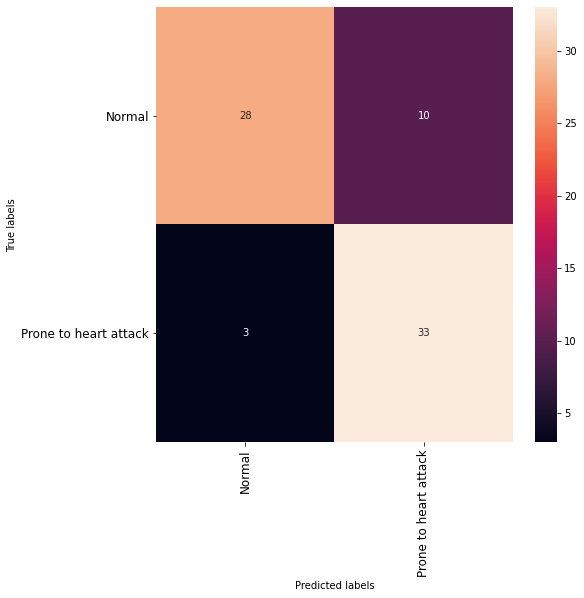

In [30]:
fig, ax = plt.subplots(figsize=(8,8))

g = sns.heatmap(cm,annot=True,ax=ax)
g.set_yticklabels(g.get_yticklabels(), rotation = 0, fontsize = 12)
g.set_xticklabels(g.get_xticklabels(), rotation = 90, fontsize = 12)
ax.xaxis.set_ticklabels(class_dict.keys()); ax.yaxis.set_ticklabels(class_dict.keys());
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');

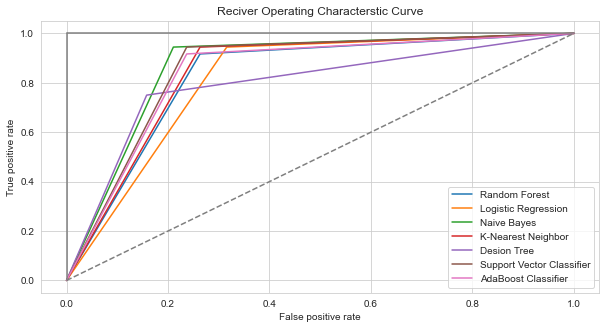

In [31]:
lr_false_positive_rate,lr_true_positive_rate,lr_threshold = metrics.roc_curve(y_test,best_estimators['LOGISTIC_REGRESSION'].predict(X_test))
nb_false_positive_rate,nb_true_positive_rate,nb_threshold = metrics.roc_curve(y_test,best_estimators['GaussianNB'].predict(X_test))
rf_false_positive_rate,rf_true_positive_rate,rf_threshold = metrics.roc_curve(y_test,best_estimators['RANDOM_FOREST'].predict(X_test))                                                             

knn_false_positive_rate,knn_true_positive_rate,knn_threshold = metrics.roc_curve(y_test,best_estimators['KNeighborsClassifier'].predict(X_test))
dt_false_positive_rate,dt_true_positive_rate,dt_threshold = metrics.roc_curve(y_test,best_estimators['DecisionTreeClassifier'].predict(X_test))
svc_false_positive_rate,svc_true_positive_rate,svc_threshold = metrics.roc_curve(y_test,best_estimators['SVM'].predict(X_test))
ada_false_positive_rate,ada_true_positive_rate,ada_threshold = metrics.roc_curve(y_test,best_estimators['AdaBoostClassifier'].predict(X_test))


sns.set_style('whitegrid')
plt.figure(figsize=(10,5))
plt.title('Reciver Operating Characterstic Curve')

plt.plot(rf_false_positive_rate,rf_true_positive_rate,label='Random Forest')
plt.plot(lr_false_positive_rate,lr_true_positive_rate,label='Logistic Regression')
plt.plot(nb_false_positive_rate,nb_true_positive_rate,label='Naive Bayes')

plt.plot(knn_false_positive_rate,knn_true_positive_rate,label='K-Nearest Neighbor')
plt.plot(dt_false_positive_rate,dt_true_positive_rate,label='Desion Tree')
plt.plot(svc_false_positive_rate,svc_true_positive_rate,label='Support Vector Classifier')
plt.plot(ada_false_positive_rate,ada_true_positive_rate,label='AdaBoost Classifier')
plt.plot([0,1],ls='--')
plt.plot([0,0],[1,0],c='.5')
plt.plot([1,1],c='.5')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.legend()
plt.show()

<ipython-input-32-33628cef99ad>:7: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  plt.barh(imp_feature['Feature'],imp_feature['Importance'],color = 'rgbkymc')


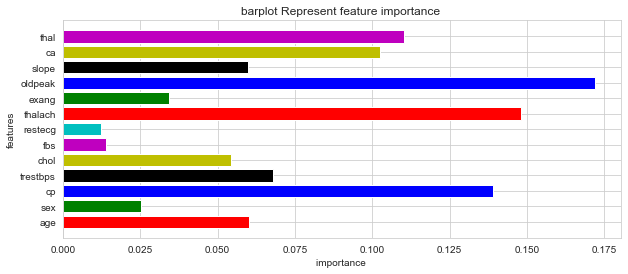

In [32]:
imp_feature = pd.DataFrame({'Feature': ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal'], 'Importance': best_estimators['RANDOM_FOREST'].feature_importances_})
plt.figure(figsize=(10,4))
plt.title("barplot Represent feature importance ")
plt.xlabel("importance ")
plt.ylabel("features")
plt.barh(imp_feature['Feature'],imp_feature['Importance'],color = 'rgbkymc')
plt.show()

Create pipeline with best selected model

In [33]:
X = df.drop('output', axis = 1)
y = df.output

from sklearn.pipeline import Pipeline
pipe = Pipeline([('scaler', StandardScaler()), ('RandomForest', RandomForestClassifier(criterion='entropy', max_depth=4, n_estimators=25,
                       random_state=13))])

pipe.fit(X,y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('RandomForest',
                 RandomForestClassifier(criterion='entropy', max_depth=4,
                                        n_estimators=25, random_state=13))])

In [34]:
test = np.array([41,0,1,130,204,0,0,172,0,1.4,2,0,2])
pipe.predict(test.reshape(1,-1))

array([1], dtype=int64)

In [35]:
import joblib 
joblib.dump(pipe, 'heart_saved_model.pkl')

['heart_saved_model.pkl']

In [36]:
import json
with open("heart_class_dictionary.json","w") as f:
    f.write(json.dumps(class_dict))